In [ ]:
import pandas as pd
import numpy as np
from scipy import integrate
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tweepy
import time
from tweepy.error import TweepError
import string
import nltk
from nltk import word_tokenize, FreqDist, pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re
from textblob import TextBlob

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
!pip install tweet-preprocessor

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


**Set credentials**

In [ ]:
#variables that contains the credentials to access Twitter API
ACCESS_TOKEN = xxx
ACCESS_SECRET = xxx
CONSUMER_KEY = xxx
CONSUMER_SECRET = xxx


#setup access to API
def connect_to_twitter_OAuth():
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    api = tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True, compression=True)
    return api


# Create API object
api = connect_to_twitter_OAuth()

**Define keyword, since and until dates**

In [ ]:
keyword = 'Cool_Dogs_'
since_date = '2021-11-01'
until_date = 2021-11-24'

**Scrape tweets**

In [ ]:
msgs = []

for tweet in tweepy.Cursor(api.search, q=[keyword], lang= 'en', since=since_date, until=until_date, wait_on_rate_limit=True).items(1000): 
    try:
      msg = [tweet.text, tweet.favorite_count, tweet.retweet_count]
      msgs.append(msg)
    except TweepError:
      time.sleep(60)
      continue

df = pd.DataFrame(msgs, columns=['text', 'likes', 'retweets'])

In [ ]:
df['hashtag'] = df['text'].apply(lambda x: re.findall(r'#(\w+)', x))

In [ ]:
#check length of dataframe

len(df)

1000

**Preprocess tweets**

In [ ]:
#forming a separate feature for cleaned tweets
import preprocessor as p

def sep_feats(raw_tweets):  

  clean = []
  for i,v in enumerate(raw_tweets):
      tmp = p.clean(v)
      clean.append(tmp)
  return clean

df['clean_v1'] = sep_feats(df.text)

In [ ]:
#tokenize & make tokens lower case

tokenizer = TweetTokenizer()

def tok_lower(cleanv1):
  return cleanv1.apply(lambda x: tokenizer.tokenize(x.lower()))

df['clean_v2'] = tok_lower(df.clean_v1)

In [ ]:
#remove punctuation

def remove_punc(cleanv2):
  punc = []
  for i in cleanv2:
    nopunc = [''.join(c for c in s if c not in string.punctuation) for s in i if len(s) >0]
    punc.append(nopunc)
  return punc

In [ ]:
df['clean_v3'] = remove_punc(df.clean_v2)

In [ ]:
#define stopwords

stop_words = stopwords.words('english')
#stop_words.extend([]) 

In [ ]:
def remove_stopwords(text):
  words = [w for w in text if w not in stop_words]
  return words

In [ ]:
df['clean_v2'] = df.clean_v2.apply(lambda x: remove_stopwords(x))

In [ ]:
#flatten df.clean

flat_list = [item for sublist in df.clean_v2 for item in sublist if len(item) > 1]

In [ ]:
#filter out nouns

def filter_nouns(lst):
  is_noun = lambda pos: pos[:2] == 'NN'

  tags = nltk.tag.pos_tag(lst)

  for i in tags:
    n = [word for (word, pos) in tags if is_noun(pos)]

  return n 

In [ ]:
n = filter_nouns(flat_list)

In [ ]:
#get word frequencies

fdist = FreqDist(n)

In [ ]:
fdist.most_common(5)

[('dogs', 274), ('join', 91), ('sale', 85), ('check', 82), ('project', 79)]

**Create word cloud from most frequent words**

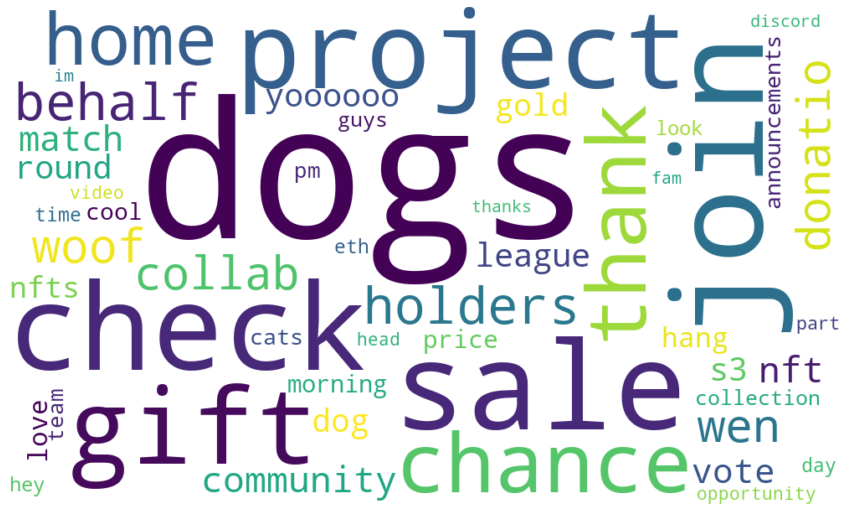

In [ ]:
#plot WordCloud

from wordcloud import WordCloud

wc = WordCloud(width=1000, height=600, background_color ='white', max_words=50).generate_from_frequencies(fdist)
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

**Get polarity and subjectivity scores**

In [ ]:
def gen_scores(clean):

  sentiment = []
  subj = []

  for i in clean:
    text = TextBlob(i)
    sentiment.append(text.sentiment.polarity)
    subj.append(text.sentiment.subjectivity)
  return sentiment, subj

pol, subj = gen_scores(df.clean_v1)

In [ ]:
df['polarity'] = pol
df['subjectivity'] = subj

In [ ]:
def plot_hist(srs):

  cm = plt.cm.get_cmap('Spectral')

  n, bins, patches = plt.hist(srs, 10)
  bin_centers = 0.5 * (bins[:-1] + bins[1:])

  # scale values to interval [0,1]
  col = bin_centers - min(bin_centers)
  col /= max(col)

  for c, p in zip(col, patches):
      plt.setp(p, 'facecolor', cm(c))

  plt.title('Polarity score distribution')

  plt.show()

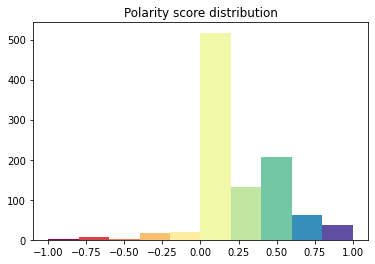

In [ ]:
#plot histogram with polarity score distribution

plot_hist(pol)

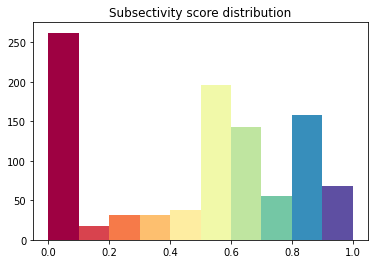

In [ ]:
#plot histogram with subsectivity score distribution

plot_hist(subj)